In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Activation, SeparableConv2D, BatchNormalization, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imshow
import matplotlib.pyplot as plt 
%matplotlib inline 


In [4]:
imagesDir = "C:\\Users\\viers\\OneDrive\\Bureaublad\\MCT\\sem4\\IndustryProject\\IndustryProject\\Data\\trainUnet\\image"
masksDir = "C:\\Users\\viers\\OneDrive\\Bureaublad\\MCT\\sem4\\IndustryProject\\IndustryProject\\Data\\trainUnet\\label"
images = sorted(
    [
        os.path.join(imagesDir, fname)
        for fname in os.listdir(imagesDir)
        if fname.endswith(".tif")
    ]
)
masks = sorted(
    [
        os.path.join(masksDir, fname)
        for fname in os.listdir(masksDir)
        if fname.endswith(".tif") and not fname.startswith(".")
    ]
)

In [5]:
im_width = 256
im_height = 256
border = 5

X = np.zeros((len(images), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(images), im_height, im_width, 1), dtype=np.float32)



In [6]:
from skimage.transform import resize
for n, id_ in enumerate(images):
    # Load images
    img_path = images[n]
    img = keras.utils.load_img(img_path, color_mode = "grayscale")
    x_img = keras.utils.img_to_array(img)
    x_img = resize(x_img, (256,256, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_path = masks[n]
    mask = keras.utils.img_to_array(keras.utils.load_img(mask_path, color_mode = "grayscale"))
    mask = resize(mask, (256,256, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0
    
print(X.size)
print(y.size)


15925248
15925248


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)


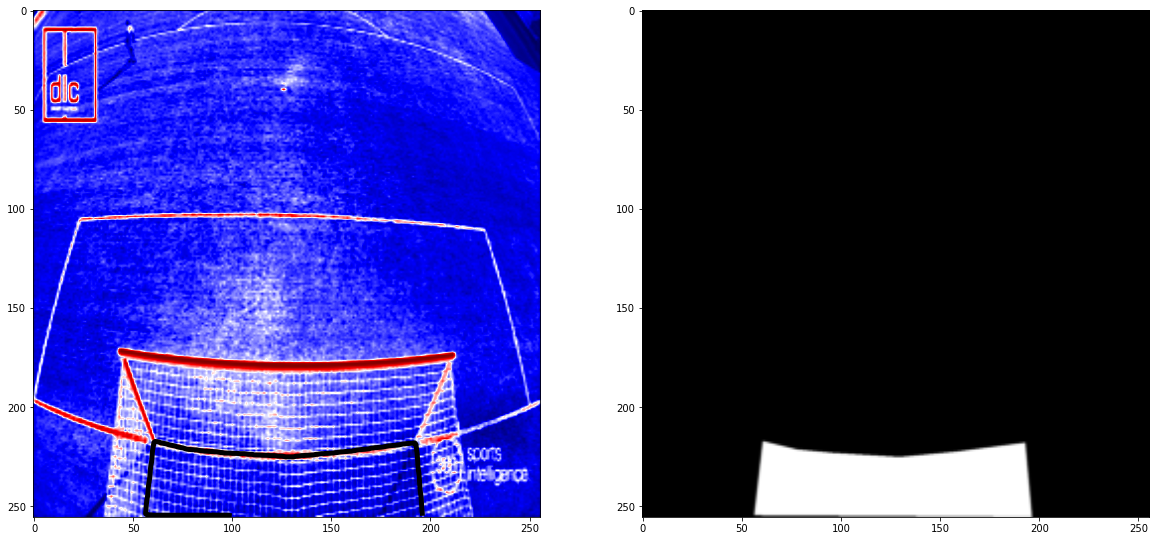

In [8]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')


In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=["accuracy"])

In [127]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('Segment_Unet_Model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [128]:
results = model.fit(X_train, y_train, batch_size=32, epochs=300, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/300
7/7 [==============================] - ETA: 0s - loss: 0.7637 - accuracy: 0.4555
Epoch 1: val_loss improved from inf to 0.61521, saving model to model-tgs-salt.h5
7/7 [==============================] - 40s 6s/step - loss: 0.7637 - accuracy: 0.4555 - val_loss: 0.6152 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 2/300
7/7 [==============================] - ETA: 0s - loss: 0.5600 - accuracy: 0.7892
Epoch 2: val_loss did not improve from 0.61521
7/7 [==============================] - 37s 5s/step - loss: 0.5600 - accuracy: 0.7892 - val_loss: 1.0691 - val_accuracy: 0.3443 - lr: 0.0010
Epoch 3/300
7/7 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.9511
Epoch 3: val_loss improved from 0.61521 to 0.60529, saving model to model-tgs-salt.h5
7/7 [==============================] - 37s 5s/step - loss: 0.4008 - accuracy: 0.9511 - val_loss: 0.6053 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 4/300
7/7 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 

7/7 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.9793
Epoch 52: val_loss improved from 0.20698 to 0.20196, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1788 - accuracy: 0.9793 - val_loss: 0.2020 - val_accuracy: 0.9764 - lr: 1.0000e-04
Epoch 53/300
7/7 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9793
Epoch 53: val_loss improved from 0.20196 to 0.19777, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1778 - accuracy: 0.9793 - val_loss: 0.1978 - val_accuracy: 0.9774 - lr: 1.0000e-04
Epoch 54/300
7/7 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9793
Epoch 54: val_loss improved from 0.19777 to 0.19472, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1769 - accuracy: 0.9793 - val_loss: 0.1947 - val_accuracy: 0.9780 - lr: 1.0000e-04
Epoch 55/300
7/7 [====================

7/7 [==============================] - 38s 5s/step - loss: 0.1572 - accuracy: 0.9793 - val_loss: 0.1599 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 78/300
7/7 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9793
Epoch 78: val_loss improved from 0.15990 to 0.15885, saving model to model-tgs-salt.h5
7/7 [==============================] - 39s 6s/step - loss: 0.1563 - accuracy: 0.9793 - val_loss: 0.1588 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 79/300
7/7 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.9793
Epoch 79: val_loss improved from 0.15885 to 0.15778, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1555 - accuracy: 0.9793 - val_loss: 0.1578 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 80/300
7/7 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9793
Epoch 80: val_loss improved from 0.15778 to 0.15647, saving model to model-tgs-salt.h5
7/7 [====================

Epoch 103/300
7/7 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9793
Epoch 103: val_loss improved from 0.13835 to 0.13718, saving model to model-tgs-salt.h5
7/7 [==============================] - 39s 5s/step - loss: 0.1376 - accuracy: 0.9793 - val_loss: 0.1372 - val_accuracy: 0.9787 - lr: 1.0000e-04
Epoch 104/300
7/7 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9793
Epoch 104: val_loss improved from 0.13718 to 0.13624, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1369 - accuracy: 0.9793 - val_loss: 0.1362 - val_accuracy: 0.9787 - lr: 1.0000e-04
Epoch 105/300
7/7 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9793
Epoch 105: val_loss improved from 0.13624 to 0.13571, saving model to model-tgs-salt.h5
7/7 [==============================] - 39s 6s/step - loss: 0.1363 - accuracy: 0.9793 - val_loss: 0.1357 - val_accuracy: 0.9786 - lr: 1.0000e-04
Epoch 106/300
7/7 [

7/7 [==============================] - 38s 5s/step - loss: 0.1215 - accuracy: 0.9793 - val_loss: 0.1207 - val_accuracy: 0.9786 - lr: 1.0000e-04
Epoch 129/300
7/7 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.9793
Epoch 129: val_loss improved from 0.12070 to 0.11971, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1209 - accuracy: 0.9793 - val_loss: 0.1197 - val_accuracy: 0.9786 - lr: 1.0000e-04
Epoch 130/300
7/7 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.9793
Epoch 130: val_loss improved from 0.11971 to 0.11939, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1203 - accuracy: 0.9793 - val_loss: 0.1194 - val_accuracy: 0.9787 - lr: 1.0000e-04
Epoch 131/300
7/7 [==============================] - ETA: 0s - loss: 0.1198 - accuracy: 0.9793
Epoch 131: val_loss improved from 0.11939 to 0.11911, saving model to model-tgs-salt.h5
7/7 [==============

Epoch 154/300
7/7 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9793
Epoch 154: val_loss improved from 0.10619 to 0.10554, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1070 - accuracy: 0.9793 - val_loss: 0.1055 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 155/300
7/7 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9793
Epoch 155: val_loss improved from 0.10554 to 0.10547, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1065 - accuracy: 0.9793 - val_loss: 0.1055 - val_accuracy: 0.9787 - lr: 1.0000e-04
Epoch 156/300
7/7 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9793
Epoch 156: val_loss improved from 0.10547 to 0.10458, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.1060 - accuracy: 0.9793 - val_loss: 0.1046 - val_accuracy: 0.9788 - lr: 1.0000e-04
Epoch 157/300
7/7 [

7/7 [==============================] - 38s 5s/step - loss: 0.0950 - accuracy: 0.9793 - val_loss: 0.0932 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 180/300
7/7 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9793
Epoch 180: val_loss did not improve from 0.09318
7/7 [==============================] - 38s 5s/step - loss: 0.0946 - accuracy: 0.9793 - val_loss: 0.0933 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 181/300
7/7 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9793
Epoch 181: val_loss improved from 0.09318 to 0.09240, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0941 - accuracy: 0.9793 - val_loss: 0.0924 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 182/300
7/7 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9793
Epoch 182: val_loss improved from 0.09240 to 0.09211, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss:

Epoch 205/300
7/7 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9793
Epoch 205: val_loss improved from 0.08292 to 0.08268, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0841 - accuracy: 0.9793 - val_loss: 0.0827 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 206/300
7/7 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9793
Epoch 206: val_loss improved from 0.08268 to 0.08207, saving model to model-tgs-salt.h5
7/7 [==============================] - 39s 6s/step - loss: 0.0837 - accuracy: 0.9793 - val_loss: 0.0821 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 207/300
7/7 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9793
Epoch 207: val_loss improved from 0.08207 to 0.08194, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0833 - accuracy: 0.9793 - val_loss: 0.0819 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 208/300
7/7 [

7/7 [==============================] - 38s 5s/step - loss: 0.0750 - accuracy: 0.9793 - val_loss: 0.0738 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 231/300
7/7 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9793
Epoch 231: val_loss improved from 0.07384 to 0.07360, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0746 - accuracy: 0.9793 - val_loss: 0.0736 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 232/300
7/7 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9793
Epoch 232: val_loss improved from 0.07360 to 0.07325, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0743 - accuracy: 0.9793 - val_loss: 0.0733 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 233/300
7/7 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9793
Epoch 233: val_loss improved from 0.07325 to 0.07293, saving model to model-tgs-salt.h5
7/7 [==============

Epoch 256/300
7/7 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9793
Epoch 256: val_loss improved from 0.06633 to 0.06615, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0667 - accuracy: 0.9793 - val_loss: 0.0662 - val_accuracy: 0.9791 - lr: 1.0000e-04
Epoch 257/300
7/7 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9793
Epoch 257: val_loss improved from 0.06615 to 0.06558, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0663 - accuracy: 0.9793 - val_loss: 0.0656 - val_accuracy: 0.9791 - lr: 1.0000e-04
Epoch 258/300
7/7 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9793
Epoch 258: val_loss did not improve from 0.06558
7/7 [==============================] - 38s 5s/step - loss: 0.0661 - accuracy: 0.9793 - val_loss: 0.0657 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 259/300
7/7 [==============================] - ETA: 

Epoch 282/300
7/7 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9793
Epoch 282: val_loss improved from 0.05954 to 0.05907, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0594 - accuracy: 0.9793 - val_loss: 0.0591 - val_accuracy: 0.9791 - lr: 1.0000e-04
Epoch 283/300
7/7 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9793
Epoch 283: val_loss did not improve from 0.05907
7/7 [==============================] - 38s 5s/step - loss: 0.0591 - accuracy: 0.9793 - val_loss: 0.0591 - val_accuracy: 0.9791 - lr: 1.0000e-04
Epoch 284/300
7/7 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9793
Epoch 284: val_loss improved from 0.05907 to 0.05854, saving model to model-tgs-salt.h5
7/7 [==============================] - 38s 5s/step - loss: 0.0588 - accuracy: 0.9793 - val_loss: 0.0585 - val_accuracy: 0.9791 - lr: 1.0000e-04
Epoch 285/300
7/7 [==============================] - ETA: 

In [129]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


1/1 [==============================] - 1s 854ms/step


In [130]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [131]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].axis('off')
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')
    
    ax[1].axis('off')
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('goal mask')

    ax[2].axis('off')
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('goal Predicted')
    
    
    ax[3].axis('off')
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('goal Predicted binary');

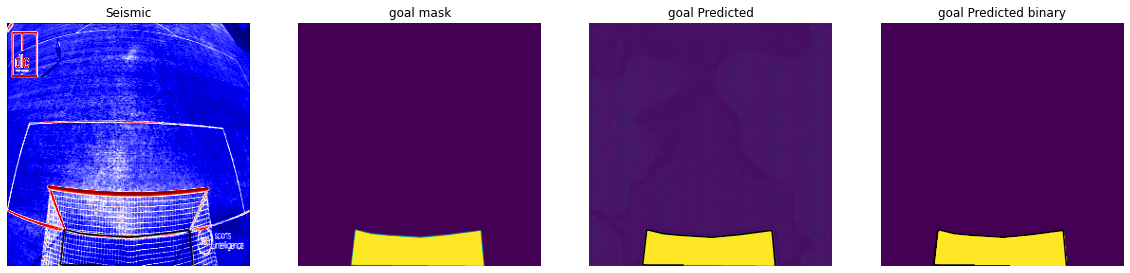

In [132]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


25


C:\Users\viers\AppData\Local\Temp\ipykernel_4080\3448506809.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 4, figsize=(20, 10))


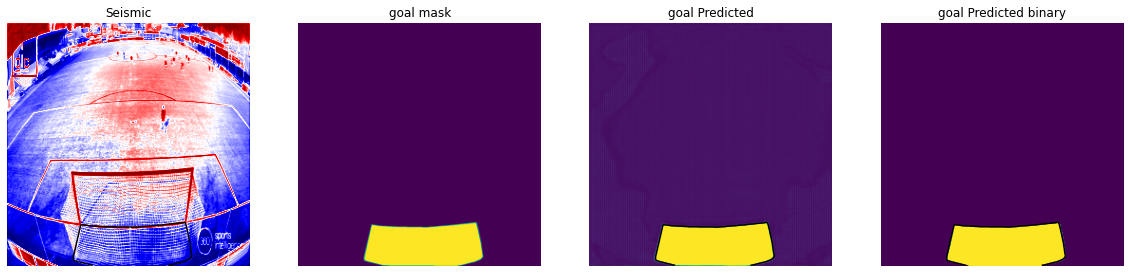

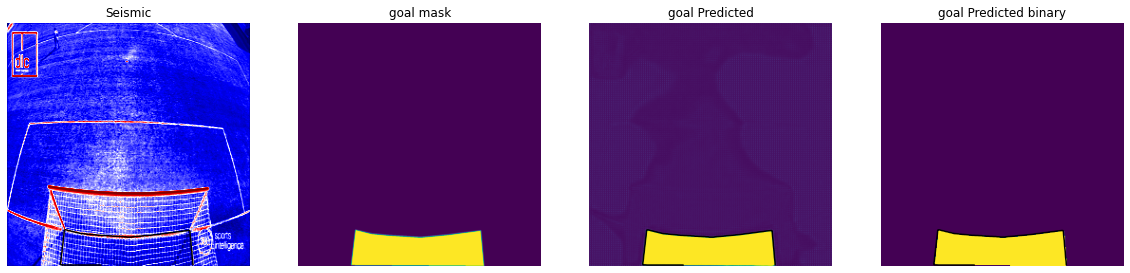

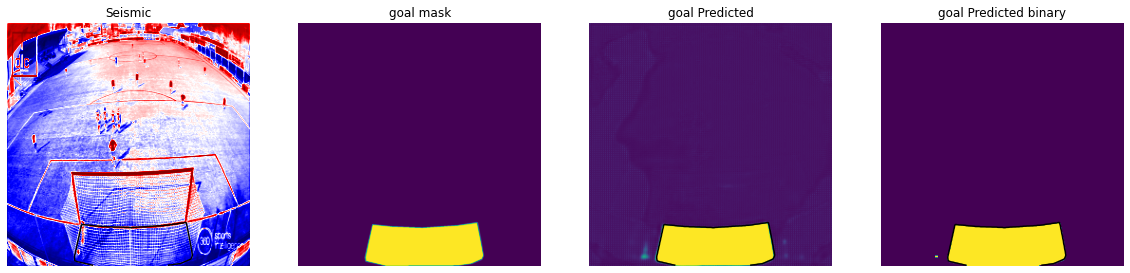

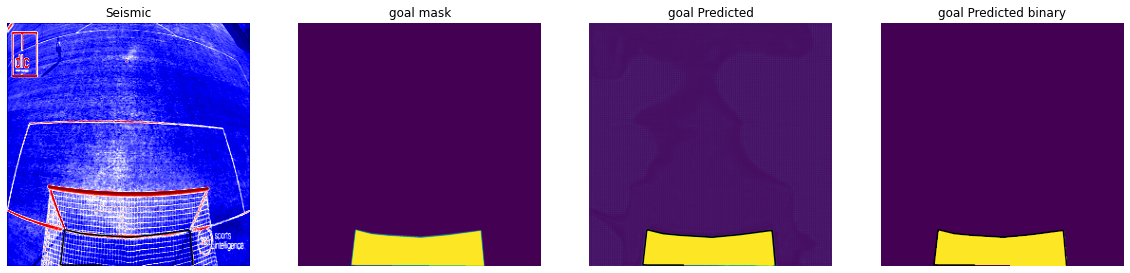

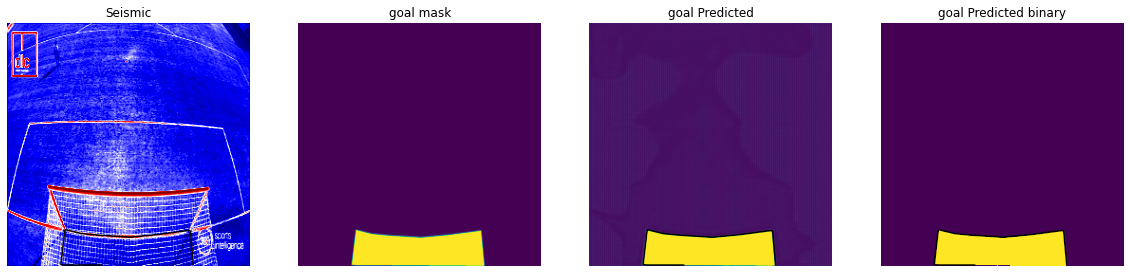

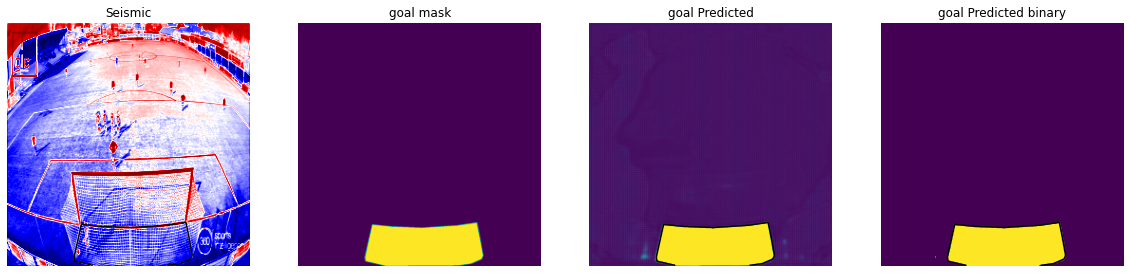

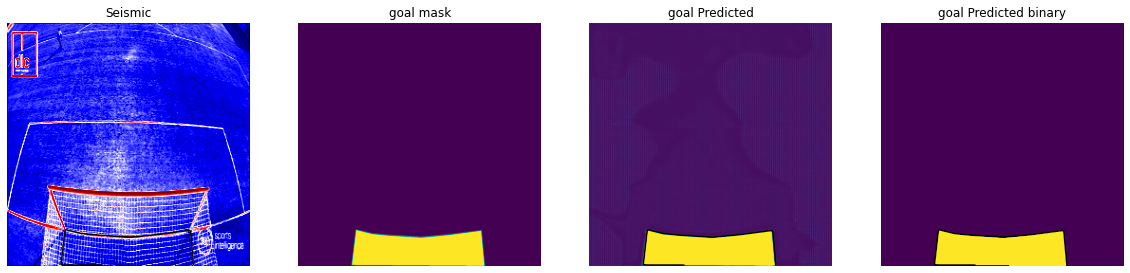

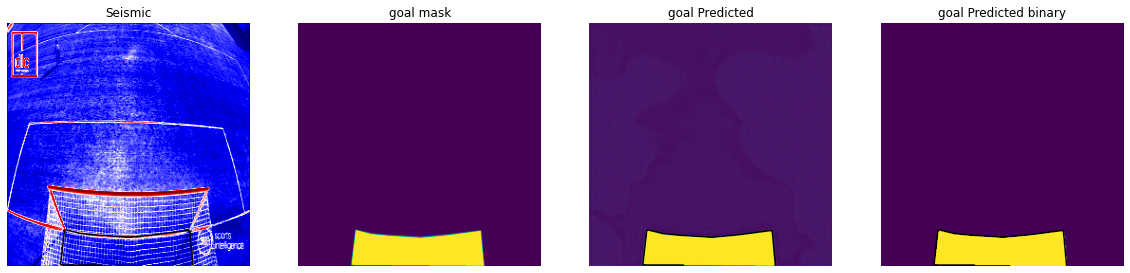

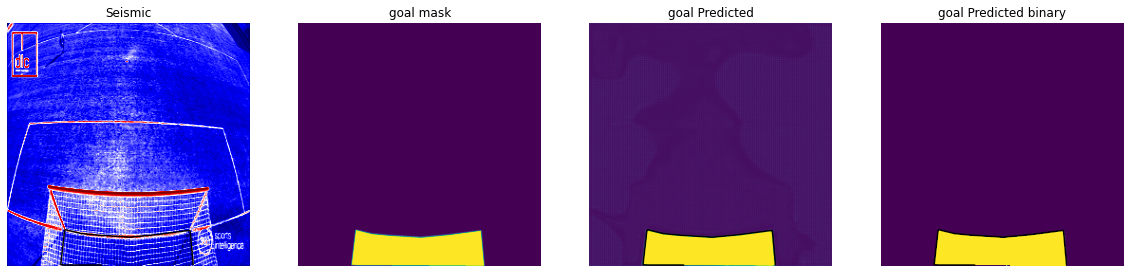

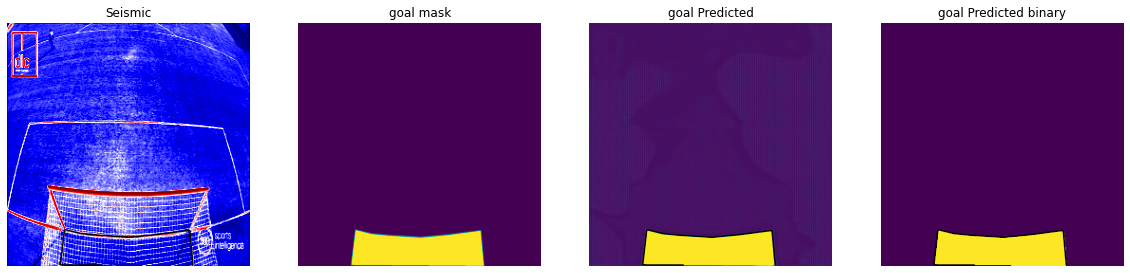

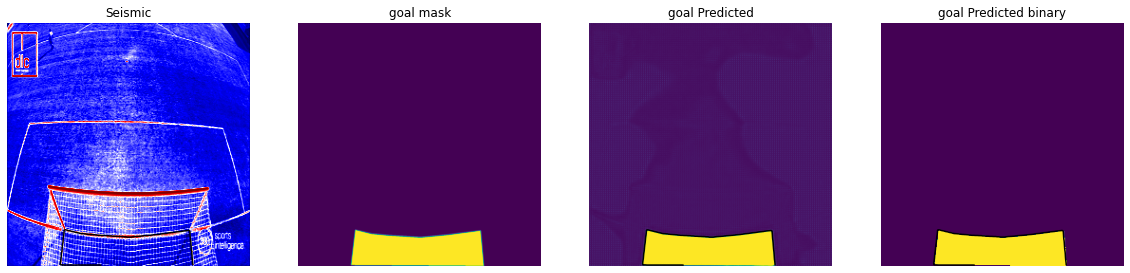

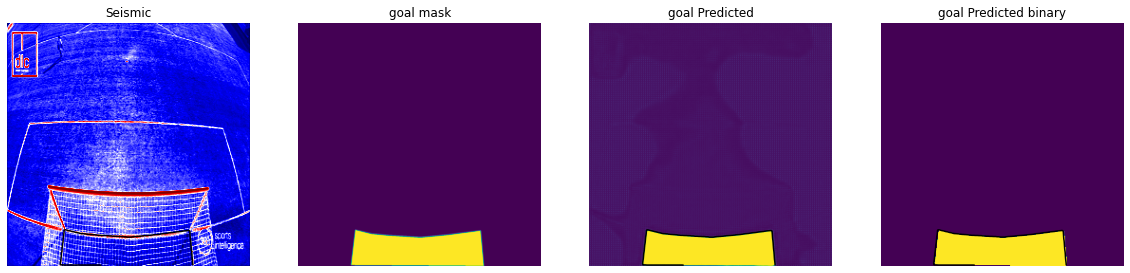

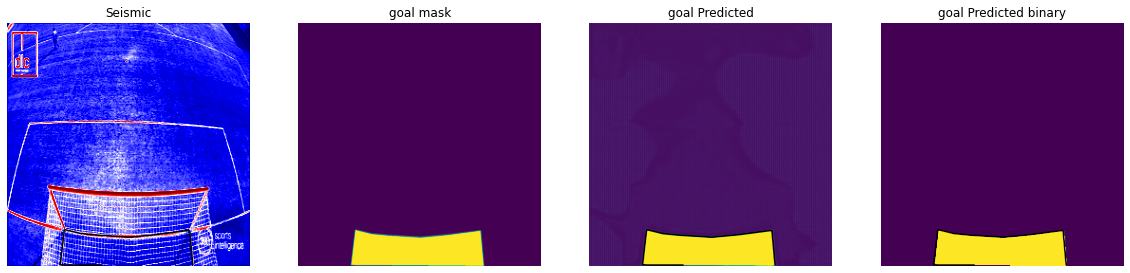

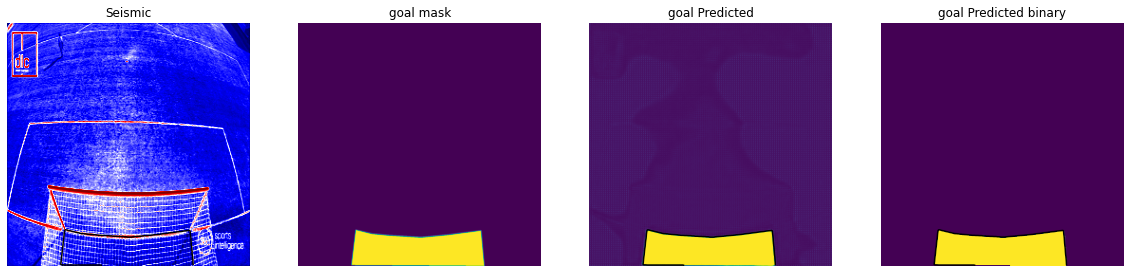

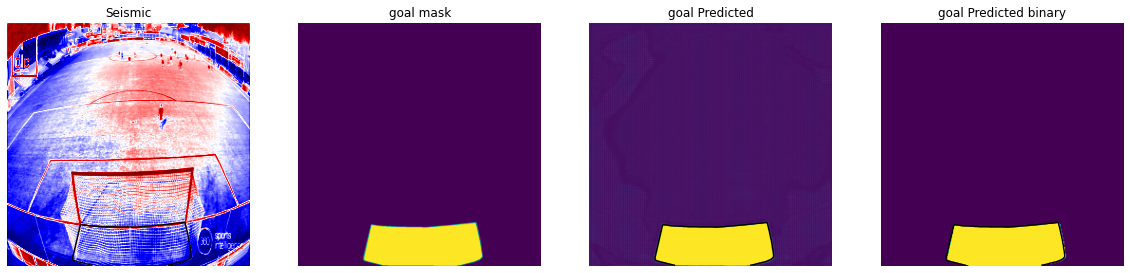

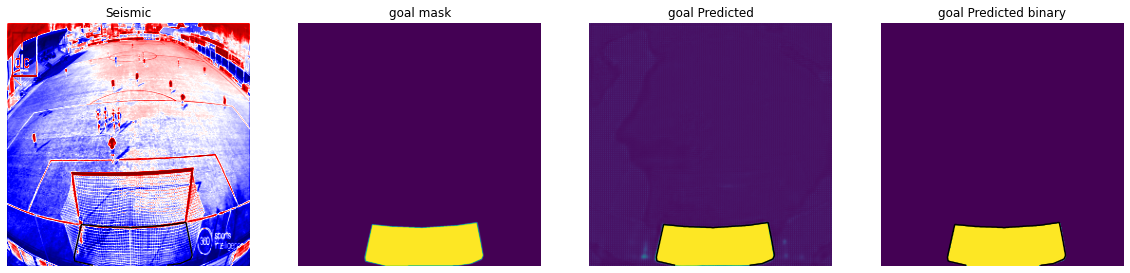

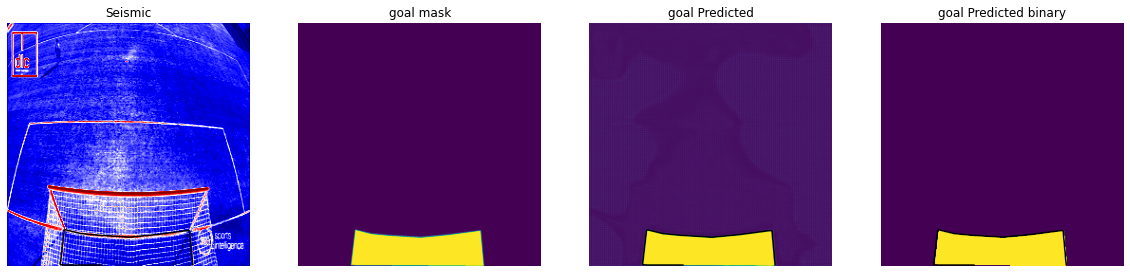

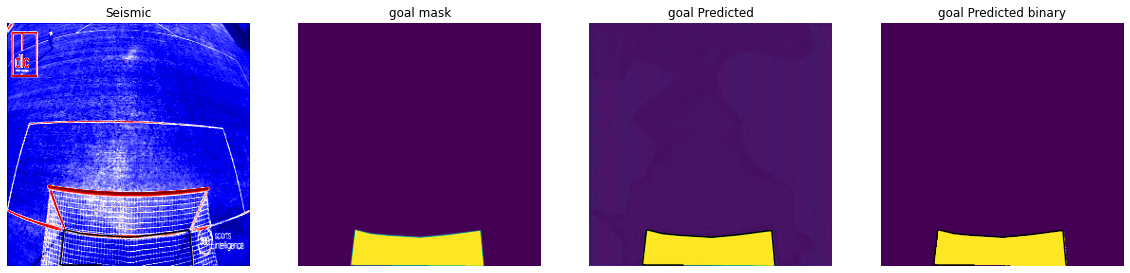

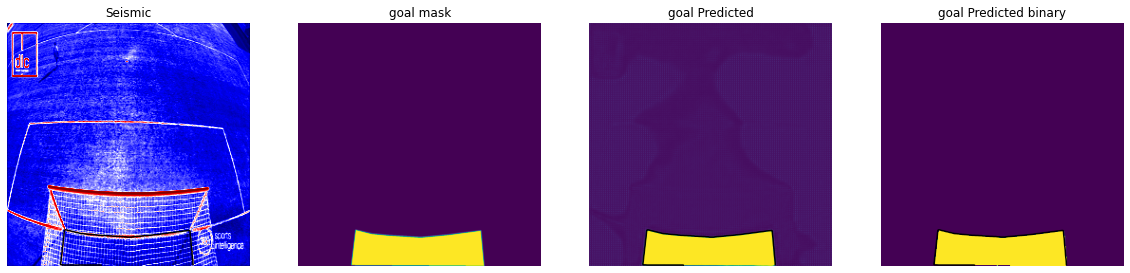

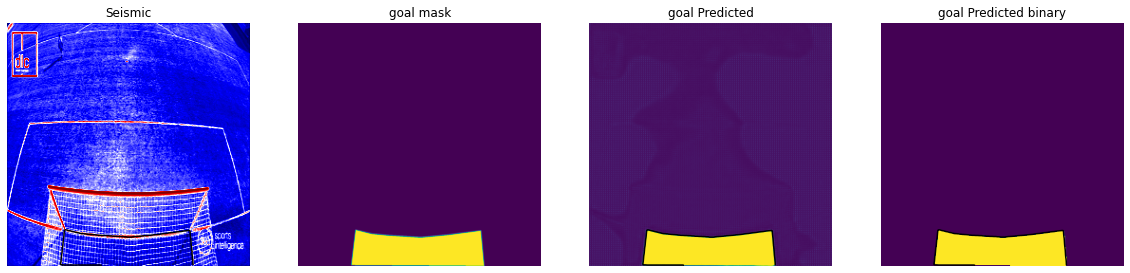

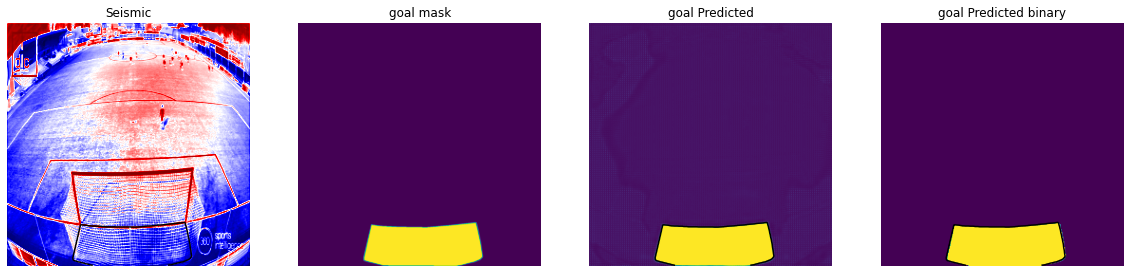

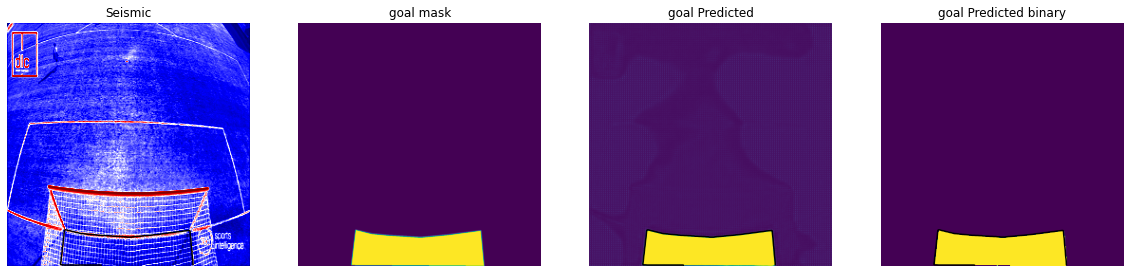

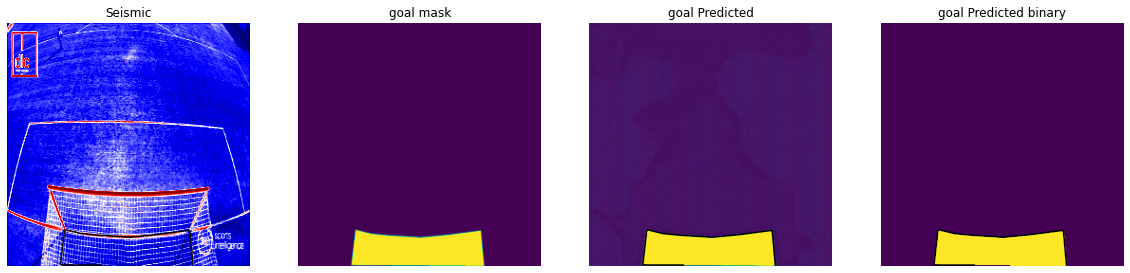

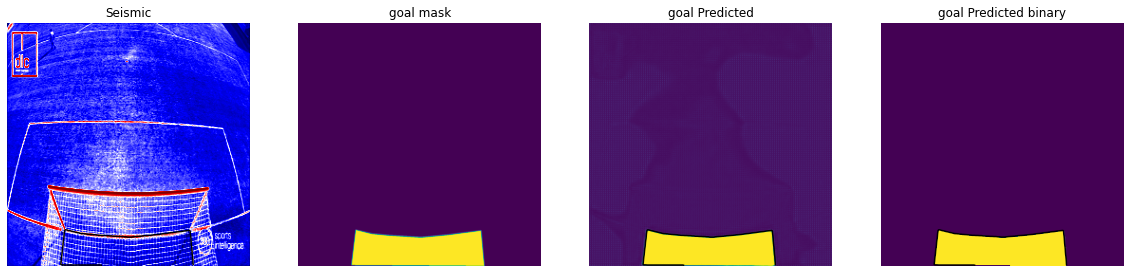

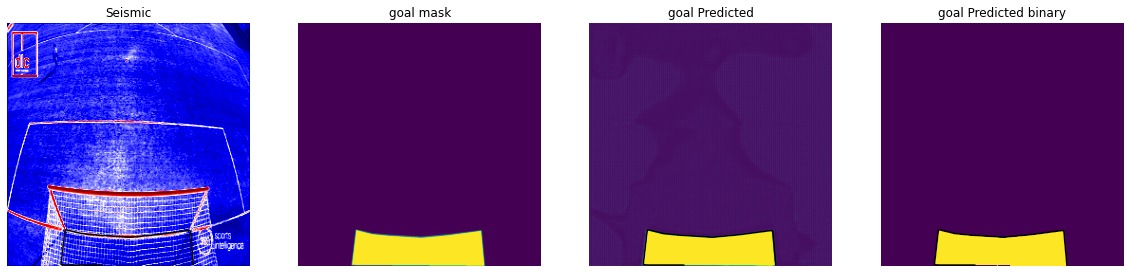

In [133]:
print(len(preds_val_t))
for i in range(0,len(preds_val_t)):
    plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=i)

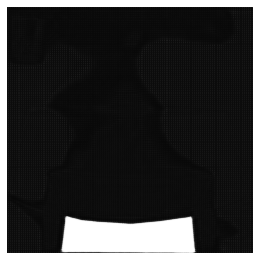

In [268]:
imshow((preds_val[1]))
plt.axis('off')
plt.show()

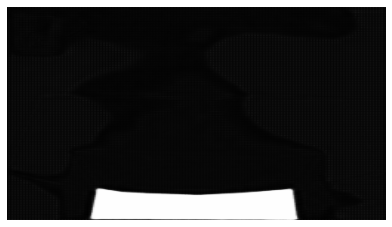

In [269]:
import cv2

img = resize(preds_val[1], (1080,1920), mode = 'constant', preserve_range = True)
img = img - img.min() # Now between 0 and 8674
img = img / img.max() * 255
predictedImg = np.uint8(img)
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_GRAY2BGR)
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_BGR2GRAY)

imshow(predictedImg)
plt.axis('off')
plt.show()

In [270]:
ret,predictedImg = cv2.threshold(predictedImg, 100, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(predictedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

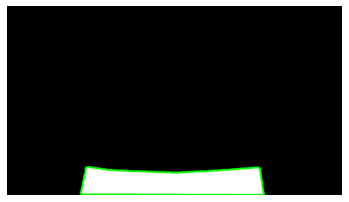

In [271]:
predictedImg = cv2.cvtColor(predictedImg, cv2.COLOR_GRAY2BGR)
cv2.drawContours(predictedImg, contours, -1, (0, 255, 0), 10)
plt.axis('off')
plt.imshow(predictedImg)


In [272]:
print(contours)

(array([[[459, 920]],

       [[458, 921]],

       [[457, 921]],

       ...,

       [[462, 920]],

       [[461, 920]],

       [[460, 920]]], dtype=int32),)


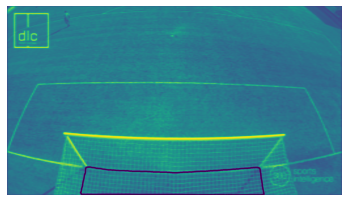

In [273]:
testImg = resize(X_train[7], (1080,1920), mode = 'constant', preserve_range = True)
cv2.drawContours(testImg, contours, -1, (0, 255, 0), 10)
plt.axis('off')
plt.imshow(testImg)


In [275]:
pip install shapely

     ---------------------------------------- 1.3/1.3 MB 10.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [285]:
from shapely.geometry import Point, Polygon
import sys
import numpy
contours = np.squeeze(contours)
numpy.set_printoptions(threshold=sys.maxsize)
print(contours)

[[ 459  920]
 [ 458  921]
 [ 457  921]
 [ 456  922]
 [ 455  923]
 [ 454  923]
 [ 453  924]
 [ 452  925]
 [ 451  926]
 [ 450  927]
 [ 450  928]
 [ 450  929]
 [ 449  930]
 [ 450  931]
 [ 450  932]
 [ 450  933]
 [ 450  934]
 [ 450  935]
 [ 450  936]
 [ 449  937]
 [ 449  938]
 [ 449  939]
 [ 449  940]
 [ 450  941]
 [ 450  942]
 [ 449  943]
 [ 449  944]
 [ 449  945]
 [ 449  946]
 [ 449  947]
 [ 449  948]
 [ 449  949]
 [ 449  950]
 [ 449  951]
 [ 448  952]
 [ 448  953]
 [ 448  954]
 [ 447  955]
 [ 447  956]
 [ 447  957]
 [ 447  958]
 [ 447  959]
 [ 446  960]
 [ 445  961]
 [ 445  962]
 [ 444  963]
 [ 444  964]
 [ 444  965]
 [ 444  966]
 [ 444  967]
 [ 443  968]
 [ 443  969]
 [ 443  970]
 [ 443  971]
 [ 442  972]
 [ 442  973]
 [ 442  974]
 [ 442  975]
 [ 442  976]
 [ 442  977]
 [ 442  978]
 [ 441  979]
 [ 441  980]
 [ 441  981]
 [ 441  982]
 [ 441  983]
 [ 441  984]
 [ 441  985]
 [ 440  986]
 [ 440  987]
 [ 440  988]
 [ 440  989]
 [ 440  990]
 [ 439  991]
 [ 439  992]
 [ 439  993]
 [ 439  994]

In [287]:
poly = Polygon(contours)

POLYGON ((459 920, 458 921, 457 921, 456 922, 455 923, 454 923, 453 924, 452 925, 451 926, 450 927, 450 928, 450 929, 449 930, 450 931, 450 932, 450 933, 450 934, 450 935, 450 936, 449 937, 449 938, 449 939, 449 940, 450 941, 450 942, 449 943, 449 944, 449 945, 449 946, 449 947, 449 948, 449 949, 449 950, 449 951, 448 952, 448 953, 448 954, 447 955, 447 956, 447 957, 447 958, 447 959, 446 960, 445 961, 445 962, 444 963, 444 964, 444 965, 444 966, 444 967, 443 968, 443 969, 443 970, 443 971, 442 972, 442 973, 442 974, 442 975, 442 976, 442 977, 442 978, 441 979, 441 980, 441 981, 441 982, 441 983, 441 984, 441 985, 440 986, 440 987, 440 988, 440 989, 440 990, 439 991, 439 992, 439 993, 439 994, 438 995, 438 996, 437 997, 437 998, 437 999, 436 1000, 436 1001, 436 1002, 436 1003, 436 1004, 435 1005, 435 1006, 435 1007, 435 1008, 435 1009, 435 1010, 435 1011, 434 1012, 434 1013, 434 1014, 434 1015, 434 1016, 434 1017, 434 1018, 433 1019, 433 1020, 433 1021, 433 1022, 433 1023, 433 1024, 43

In [288]:
p1 = Point(1137,963)
p2 = Point(1147,354)
p3 = Point(736,1011)
p4 = Point(729,455)
print(p1.within(poly))
print(p2.within(poly))
print(p3.within(poly))
print(p4.within(poly))


True
False
True
False
